## Processing User Data with the New Fields ##

In [61]:
# install the packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time, timedelta

In [62]:
import import_ipynb
import User_Data_Generation
userdata = User_Data_Generation.users

In [63]:
# Process data: convert fields into the right data types

user_data = userdata.copy()
user_data["timestamp"] = pd.to_datetime(user_data["timestamp"])

# add new date column 

user_data["Date"] = pd.to_datetime(user_data["timestamp"]).dt.normalize()

In [64]:
user_data.head()

,timestamp,user_id,action,category,product_name,price,Date
0,2023-01-01 06:58:38,f29d8e71-5adc-430b-a701-0fefeef20098,"view, view, view, click, click, view, purchase",Books,The Hobbit,20.38,2023-01-01
1,2023-01-01 13:35:02,365f31bb-9153-4df2-a830-94abb83f5332,"click, purchase",Home,Air Purifier,114.78,2023-01-01
2,2023-01-01 11:12:11,9a4598e2-6e24-4f86-a105-4dd7adc6e705,"click, click, click, purchase",Clothing,Sneakers,70.54,2023-01-01
3,2023-01-01 06:51:27,53948070-6d9b-481d-b9b3-9c081692f6fc,"click, click, purchase",Electronics,TV,1105.97,2023-01-01
4,2023-01-01 22:59:05,8525dfd8-4a3e-45ab-8485-4856fa0f2806,"click, view, view, view, purchase",Home,Robot Vacuum,367.95,2023-01-01


In [65]:
# Tackling "Action" field: extracting user actions to define attribution 

# Function to extract interactions
def extract_interactions(history, position):
    # Split the history string into a list
    entries = history.split(", ")
    # Check if the requested position exists (from the end)
    if len(entries) >= position:
        return entries[-position]
    return None  # Return None if the position doesn't exist

# Apply the function to create the columns
user_data["Last Interaction"] = user_data["action"].apply(lambda x: extract_interactions(x, 1))
user_data["Third Interaction"] = user_data["action"].apply(lambda x: extract_interactions(x, 2))
user_data["Second Interaction"] = user_data["action"].apply(lambda x: extract_interactions(x, 3))
user_data["First Interaction"] = user_data["action"].apply(lambda x: extract_interactions(x, 4))

In [66]:
# Create a new field "Sales_Channel" for attribution & further insights on the MMM

# Define probabilities for Sales_Channel when Last Interaction is "purchase"
sales_channel_probs = {
    "Search": 0.4,
    "Social": 0.25,
    "Video": 0.15,
    "Display": 0.10,
    "Digital Audio": 0.10
}

# Function to determine Sales_Channel
def determine_sales_channel(last_interaction):
    if last_interaction in ["view", "click"]:
        return "Offline"
    else:
        return np.random.choice(
            list(sales_channel_probs.keys()), 
            p=list(sales_channel_probs.values())
        )

# Apply the function to create the Sales_Channel column
user_data["Sales_Channel"] = user_data["Last Interaction"].apply(determine_sales_channel)

In [67]:
# Testing a new function in a copied dataframe
user_data2 = user_data.copy()

# Getting view counts and click counts out of the action section

click_probs = [0.35, 0.25, 0.15, 0.15, 0.1] # Search > Social > Video > Display > Audio
view_probs = [0.1, 0.2, 0.25, 0.3, 0.15]  # Display > Social > Video > Search > Audio
categories = ["Search", "Social", "Video", "Display", "Audio"]

# Function to distribute actions
def distribute_actions(actions):
    purchases = actions.count("purchase")
    clicks = actions.count("click") + purchases  # Purchases include 1 click each
    views = actions.count("view") + clicks  # Clicks (and purchases) include 1 view each
    
    # Distribute views and clicks based on probabilities
    view_distribution = np.random.multinomial(views, view_probs)
    click_distribution = np.random.multinomial(clicks, click_probs)
    
    # Create output dictionary
    output = {f"{category}_Views": view_distribution[i] for i, category in enumerate(categories)}
    output.update({f"{category}_Clicks": click_distribution[i] for i, category in enumerate(categories)})
    return output

# Apply the function and expand the result into new columns
distributions = user_data2["action"].apply(distribute_actions)
distributions_user_data2 = pd.DataFrame(list(distributions))

# Add the new columns to the original DataFrame
user_data3 = pd.concat([user_data2, distributions_user_data2], axis=1)

In [68]:
# Feature Engineering

user_data3["Sales_Channel"].unique() # checking the number of unique values in Sales Channel
user_data3["category"].unique() # checking the number of unique values in Category
user_data4 = user_data3.copy()

# Import scikit-learn for OHE

from sklearn.preprocessing import OneHotEncoder

# Initialize the OneHotEncoder
encoder = OneHotEncoder(drop=None, sparse_output=False)

# OneHotEncode "category"
category_encoded = encoder.fit_transform(user_data4[["category"]])
category_col_encoded = encoder.get_feature_names_out(["category"])
user_data4[category_col_encoded] = category_encoded  # Add encoded columns without removing the original

# OneHotEncode "Sales_Channel"
saleschannel_encoded = encoder.fit_transform(user_data4[["Sales_Channel"]])
sales_cha_encoded = encoder.get_feature_names_out(["Sales_Channel"])
user_data4[sales_cha_encoded] = saleschannel_encoded  # Add encoded columns without removing the original

# Display updated columns
print(user_data4.columns)


Index(['timestamp', 'user_id', 'action', 'category', 'product_name', 'price',
       'Date', 'Last Interaction', 'Third Interaction', 'Second Interaction',
       'First Interaction', 'Sales_Channel', 'Search_Views', 'Social_Views',
       'Video_Views', 'Display_Views', 'Audio_Views', 'Search_Clicks',
       'Social_Clicks', 'Video_Clicks', 'Display_Clicks', 'Audio_Clicks',
       'category_Books', 'category_Clothing', 'category_Electronics',
       'category_Home', 'Sales_Channel_Digital Audio', 'Sales_Channel_Display',
       'Sales_Channel_Offline', 'Sales_Channel_Search', 'Sales_Channel_Social',
       'Sales_Channel_Video'],
      dtype='object')


In [69]:
ud = user_data4
ud.head()
ud.columns

Index(['timestamp', 'user_id', 'action', 'category', 'product_name', 'price',
       'Date', 'Last Interaction', 'Third Interaction', 'Second Interaction',
       'First Interaction', 'Sales_Channel', 'Search_Views', 'Social_Views',
       'Video_Views', 'Display_Views', 'Audio_Views', 'Search_Clicks',
       'Social_Clicks', 'Video_Clicks', 'Display_Clicks', 'Audio_Clicks',
       'category_Books', 'category_Clothing', 'category_Electronics',
       'category_Home', 'Sales_Channel_Digital Audio', 'Sales_Channel_Display',
       'Sales_Channel_Offline', 'Sales_Channel_Search', 'Sales_Channel_Social',
       'Sales_Channel_Video'],
      dtype='object')

## Joining User Data with the Macro & Spend Data ##

In [70]:
# importing other notebook to join macro table with the user data

import import_ipynb
import MMM_macro_data 
daily = MMM_macro_data.daily

In [71]:
# Bringing the sum of revenue and sales on a daily rollup 

# Define the feature fields for summation
feature_engineered_sum = [
    'Search_Views', 'Social_Views', 'Video_Views', 'Display_Views', 'Audio_Views',
    'Search_Clicks', 'Social_Clicks', 'Video_Clicks', 'Display_Clicks', 'Audio_Clicks',
    'category_Books', 'category_Clothing', 'category_Electronics', 'category_Home',
    'Sales_Channel_Digital Audio', 'Sales_Channel_Display', 'Sales_Channel_Offline',
    'Sales_Channel_Search', 'Sales_Channel_Social', 'Sales_Channel_Video'
]

# Base aggregation dictionary
agg_dictionary = {
    "revenue": ("price", "sum"),
    "salescount": ("user_id", "count"),
    "searchclicks": ("Search_Clicks", "sum"),
    "search_impr": ("Search_Views", "sum")
}

# Update the dictionary dynamically for all feature fields
agg_dictionary.update({field: (field, "sum") for field in feature_engineered_sum})


# Perform groupby operation
ud_join = ud.groupby("Date").agg(**agg_dictionary)

# check the values

ud_join.head()

,revenue,salescount,searchclicks,search_impr,Search_Views,Social_Views,Video_Views,Display_Views,Audio_Views,Search_Clicks,...,category_Books,category_Clothing,category_Electronics,category_Home,Sales_Channel_Digital Audio,Sales_Channel_Display,Sales_Channel_Offline,Sales_Channel_Search,Sales_Channel_Social,Sales_Channel_Video
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,180867.31,930,697,334,334,575,818,942,475,697,...,230.0,224.0,234.0,242.0,94.0,87.0,19.0,378.0,232.0,120.0
2023-01-02,88509.59,682,671,346,346,703,842,1016,507,671,...,163.0,157.0,172.0,190.0,82.0,56.0,69.0,236.0,145.0,94.0
2023-01-03,92090.62,668,680,375,375,719,866,1073,497,680,...,162.0,161.0,171.0,174.0,62.0,48.0,81.0,230.0,148.0,99.0
2023-01-04,95324.81,665,662,377,377,637,796,1015,489,662,...,149.0,165.0,184.0,167.0,62.0,56.0,76.0,235.0,147.0,89.0
2023-01-05,74536.75,601,627,298,298,593,790,918,465,627,...,144.0,174.0,147.0,136.0,41.0,57.0,75.0,224.0,133.0,71.0


In [72]:
mmm_1 = daily.merge(ud_join, on = "Date", how="left") # Joining the user data with the macro data

In [73]:
# Macro data exploration

mmm_1.head()


,Date,Month,Year,Weekday,Trend_Factor,Promo_Exists,Consumer_Index,Inflation_Rate,Budget_Factor,Search_Factor,...,category_Books,category_Clothing,category_Electronics,category_Home,Sales_Channel_Digital Audio,Sales_Channel_Display,Sales_Channel_Offline,Sales_Channel_Search,Sales_Channel_Social,Sales_Channel_Video
0,2023-01-01,1,2023,6,1.05,0,110.7,8.7,1766183,0.53,...,230.0,224.0,234.0,242.0,94.0,87.0,19.0,378.0,232.0,120.0
1,2023-01-02,1,2023,0,1.05,0,110.7,8.7,1766183,0.53,...,163.0,157.0,172.0,190.0,82.0,56.0,69.0,236.0,145.0,94.0
2,2023-01-03,1,2023,1,1.05,0,110.7,8.7,1766183,0.53,...,162.0,161.0,171.0,174.0,62.0,48.0,81.0,230.0,148.0,99.0
3,2023-01-04,1,2023,2,1.05,0,110.7,8.7,1766183,0.53,...,149.0,165.0,184.0,167.0,62.0,56.0,76.0,235.0,147.0,89.0
4,2023-01-05,1,2023,3,1.05,0,110.7,8.7,1766183,0.53,...,144.0,174.0,147.0,136.0,41.0,57.0,75.0,224.0,133.0,71.0


## MMM Joined Table EDA

In [74]:
mmm_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 51 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         731 non-null    datetime64[ns]
 1   Month                        731 non-null    int64         
 2   Year                         731 non-null    int64         
 3   Weekday                      731 non-null    int64         
 4   Trend_Factor                 731 non-null    float64       
 5   Promo_Exists                 731 non-null    int64         
 6   Consumer_Index               731 non-null    float64       
 7   Inflation_Rate               731 non-null    float64       
 8   Budget_Factor                731 non-null    int64         
 9   Search_Factor                731 non-null    float64       
 10  Display_Factor               731 non-null    float64       
 11  Video_Factor                 731 non-null    

In [ ]:
# Checking correlation & distribution

# Filter columns that contain 'Spend' in their names
spendc = [col for col in mmm_1.columns if "Spend" in col] + ["revenue", "salescount"]

# Create pairplot
sns.pairplot(mmm_1[spendc], diag_kind="kde", corner=True, height=2.5)

# Show the plot
plt.suptitle("Pairplot of Spend Fields", y=1.02)
plt.show()

In [ ]:
# Ensure correct syntax with explicit data parameter
sns.lineplot(data=mmm_1, x="Date", y="salescount")
plt.title("Sales Count Over Time")
plt.xlabel("Date")
plt.ylabel("Sales Count")
plt.xticks(rotation=45)
plt.show()

# Final Table

In [75]:
# Drop columns containing "Factor" and specific columns 'searchclicks' and 'search_impr' to prevent data leakage

mmm_2 = mmm_1.copy()

mmm_2_columns_to_drop = [col for col in mmm_2.columns if "Factor" in col] + ['searchclicks', 'search_impr']
mmm_2 = mmm_2.drop(columns=mmm_2_columns_to_drop)

mmm_3 = mmm_2.copy()

mmm_3.head()

,Date,Month,Year,Weekday,Promo_Exists,Consumer_Index,Inflation_Rate,Search_Spend,Display_Spend,Video_Spend,...,category_Books,category_Clothing,category_Electronics,category_Home,Sales_Channel_Digital Audio,Sales_Channel_Display,Sales_Channel_Offline,Sales_Channel_Search,Sales_Channel_Social,Sales_Channel_Video
0,2023-01-01,1,2023,6,0,110.7,8.7,29977.809599,4207.871135,3679.209237,...,230.0,224.0,234.0,242.0,94.0,87.0,19.0,378.0,232.0,120.0
1,2023-01-02,1,2023,0,0,110.7,8.7,31524.271086,3939.230113,3810.356373,...,163.0,157.0,172.0,190.0,82.0,56.0,69.0,236.0,145.0,94.0
2,2023-01-03,1,2023,1,0,110.7,8.7,36393.876313,3499.241457,3624.383370,...,162.0,161.0,171.0,174.0,62.0,48.0,81.0,230.0,148.0,99.0
3,2023-01-04,1,2023,2,0,110.7,8.7,35552.350332,3915.009144,4028.750834,...,149.0,165.0,184.0,167.0,62.0,56.0,76.0,235.0,147.0,89.0
4,2023-01-05,1,2023,3,0,110.7,8.7,30540.154875,3809.230968,3649.449724,...,144.0,174.0,147.0,136.0,41.0,57.0,75.0,224.0,133.0,71.0


In [76]:
# Weekly Data

import pandas as pd

# Function to convert daily data into weekly data
def convert_to_weekly(mmm_3):
    """
    Converts daily data into weekly data.

    Steps:
    1. Converts Month, Year, and Weekday into appropriate formats.
    2. Groups monthly values by Month_Year.
    3. Groups all other numeric columns by Week (starting Monday).
    4. Aggregates weekly values by sum.

    Args:
        mmm_3 (pd.DataFrame): Daily data with a 'Date' column in 'YYYY-MM-DD' format.

    Returns:
        pd.DataFrame: Aggregated weekly data with a 'Week' column representing the start of the week (Monday).
    """
    # Ensure Date column is in datetime format
    mmm_3["Date"] = pd.to_datetime(mmm_3["Date"])

    # Convert Month_Year into datetime format
    mmm_3["Month_Year"] = pd.to_datetime(mmm_3[["Year", "Month"]].assign(Day=1))

    # Convert Weekday into string format
    mmm_3["Weekday"] = mmm_3["Weekday"].astype(str)

    # Create a 'Week' column representing the start of the week (Monday)
    mmm_3["Week"] = mmm_3["Date"] - pd.to_timedelta(mmm_3["Date"].dt.weekday, unit="D")

    # Define aggregation rules
    monthly_columns = ["Promo_Exists", "Consumer_Index", "Inflation_Rate", "Gross_Rating_Point"]
    grouped_columns = {col: "first" for col in monthly_columns}  # These remain constant for a month

    # Add all other numeric columns with sum
    for col in mmm_3.select_dtypes(include="number").columns:
        if col not in monthly_columns and col != "Month_Year":  # Avoid re-grouping Month_Year
            grouped_columns[col] = "sum"

    # Group by Week and aggregate
    mmm_weekly = mmm_3.groupby(["Week", "Month_Year"]).agg(grouped_columns).reset_index()

    return mmm_weekly

# Example usage:

mmm_weekly = convert_to_weekly(mmm_3)


In [77]:
mmm_weekly.columns

Index(['Week', 'Month_Year', 'Promo_Exists', 'Consumer_Index',
       'Inflation_Rate', 'Gross_Rating_Point', 'Month', 'Year', 'Search_Spend',
       'Display_Spend', 'Video_Spend', 'Social_Spend', 'Digital_Audio_Spend',
       'TV_Spend', 'Radio_Spend', 'OOH_Spend', 'revenue', 'salescount',
       'Search_Views', 'Social_Views', 'Video_Views', 'Display_Views',
       'Audio_Views', 'Search_Clicks', 'Social_Clicks', 'Video_Clicks',
       'Display_Clicks', 'Audio_Clicks', 'category_Books', 'category_Clothing',
       'category_Electronics', 'category_Home', 'Sales_Channel_Digital Audio',
       'Sales_Channel_Display', 'Sales_Channel_Offline',
       'Sales_Channel_Search', 'Sales_Channel_Social', 'Sales_Channel_Video'],
      dtype='object')

In [78]:
# Turn Monthly Data into CSV to use it in different models such as LightweightMMM & PyMC 

mmm_weekly.to_csv("weekly_data.csv", index=False)

# Marketing Mix Modelling: Baseline Model

## Adstock & Carryover Factor 

Before we begin to build the baseline models and further, the definition of the adstock function would be more accurate to make our models perform at the level of industry standards.

In Marketing Mix Modeling (MMM), Adstock and Carryover Effect help measure the delayed impact of advertising spend over time.

Adstock Effect: Ads don’t just impact sales immediately—they have a lingering effect. A portion of the impact from one period (week) “carries over” into future weeks. This is crucial for modeling long-term ad influence.

Carryover Factor: This represents how much of the previous period’s ad effect remains in the next period. If it’s 0.5, then 50% of last week’s effect carries over.

In [79]:
def adstock_transform(data, spend_column, carryover_factor):
    """
    Applies Adstock transformation to an advertising spend column.

    Args:
        data (pd.DataFrame): DataFrame containing weekly data.
        spend_column (str): The name of the ad spend column to transform.
        carryover_factor (float): The carryover effect (0 to 1).

    Returns:
        pd.Series: Transformed ad spend with Adstock effect.
    """
    adstocked_values = []
    prev_adstock = 0  # Initial carryover effect is 0

    for spend in data[spend_column]:
        current_adstock = spend + (prev_adstock * carryover_factor)
        adstocked_values.append(current_adstock)
        prev_adstock = current_adstock  # Update carryover effect

    return pd.Series(adstocked_values, index=data.index)

# Define different carryover factors
offline_carryover_factor = 0.3
online_carryover_factor = 0.5

# Define offline and online spend categories
offline_channels = ["TV_Spend", "Radio_Spend", "OOH_Spend"]

# Find all columns that end with "_Spend"
spend_columns = [col for col in mmm_weekly.columns if col.endswith("_Spend")]

# Apply adstock transformation based on category
for col in spend_columns:
    carryover_factor = offline_carryover_factor if col in offline_channels else online_carryover_factor
    mmm_weekly[col + "_Adstock"] = adstock_transform(mmm_weekly, col, carryover_factor)

# Now, mmm_weekly contains new columns with Adstocked ad spend values

In [80]:
mmm_weekly.head()

,Week,Month_Year,Promo_Exists,Consumer_Index,Inflation_Rate,Gross_Rating_Point,Month,Year,Search_Spend,Display_Spend,...,Sales_Channel_Social,Sales_Channel_Video,Search_Spend_Adstock,Display_Spend_Adstock,Video_Spend_Adstock,Social_Spend_Adstock,Digital_Audio_Spend_Adstock,TV_Spend_Adstock,Radio_Spend_Adstock,OOH_Spend_Adstock
0,2022-12-26,2023-01-01,0,110.7,8.7,117.6,1,2023,29977.809599,4207.871135,...,232.0,120.0,29977.809599,4207.871135,3679.209237,4544.901565,2873.943003,8441.358831,2796.122756,3581.875562
1,2023-01-02,2023-01-01,0,110.7,8.7,117.6,7,14161,235357.151229,26247.843753,...,1201.0,749.0,250346.056029,28351.779320,27595.806750,32252.627622,23537.994197,51307.797221,17889.698475,26491.139445
2,2023-01-09,2023-01-01,0,110.7,8.7,117.6,7,14161,234186.938263,26545.377010,...,1205.0,718.0,359359.966277,40721.266670,39828.044517,48278.767882,34261.488038,68756.610471,22999.485398,34172.154767
3,2023-01-16,2023-01-01,0,110.7,8.7,117.6,7,14161,236415.991241,25535.800231,...,1144.0,695.0,416095.974380,45896.433567,46840.980750,55471.369519,39360.460780,72191.351037,23632.666305,36960.846071
4,2023-01-23,2023-01-01,0,110.7,8.7,117.6,7,14161,236796.392545,26114.634553,...,1186.0,748.0,444844.379735,49062.851336,49850.096338,57672.017315,41973.788808,71394.920659,24514.634994,36987.176750


Below is the simple baseline model based on the linear regression.

#### Simple Baseline Model

In [81]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd

# Prepare the data
# Assuming `mmm_weekly` is the grouped weekly DataFrame from the previous step

# Define predictors (X) and target variable (y)
# Use Adstock-transformed spend variables
predictors = [
    "Promo_Exists", "Consumer_Index", "Inflation_Rate",
    "Search_Spend_Adstock", "Display_Spend_Adstock", "Video_Spend_Adstock", "Social_Spend_Adstock",
    "Digital_Audio_Spend_Adstock", "TV_Spend_Adstock", "Radio_Spend_Adstock", "OOH_Spend_Adstock",
    "Gross_Rating_Point",
    "Sales_Channel_Digital Audio", "Sales_Channel_Display",
    "Sales_Channel_Offline", "Sales_Channel_Search", "Sales_Channel_Social",
    "Sales_Channel_Video", "Search_Views", "Social_Views", "Video_Views",
    "Display_Views", "Audio_Views", "Search_Clicks", "Social_Clicks",
    "Video_Clicks", "Display_Clicks", "Audio_Clicks", "category_Books",
    "category_Clothing", "category_Electronics", "category_Home"
]

target = "revenue"

# Apply MinMaxScaler to selected columns
scaler_columns = [col for col in predictors if 
                  "_Views" in col or "_Clicks" in col or "category_" in col or "Sales_Channel_" in col]

scaler = MinMaxScaler()
mmm_weekly[scaler_columns] = scaler.fit_transform(mmm_weekly[scaler_columns])

X = mmm_weekly[predictors]
y = mmm_weekly[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Print evaluation metrics
print("Linear Regression Model Evaluation:")
print(f"R-squared (R²): {r2:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")

# Display the coefficients
coefficients = pd.DataFrame({
    "Feature": predictors,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)

print("\nFeature Coefficients:")
print(coefficients)

# Add predictions to the DataFrame for further analysis
mmm_weekly["predicted_revenue"] = model.predict(X)

# Display a sample of the updated DataFrame
print("\nUpdated DataFrame with Predictions:")
print(mmm_weekly[["Week", "revenue", "predicted_revenue"]].head())

Linear Regression Model Evaluation:
R-squared (R²): 0.89
Mean Squared Error (MSE): 120185859195.63
Root Mean Squared Error (RMSE): 346678.32
Mean Absolute Percentage Error (MAPE): 31.94%

Feature Coefficients:
                        Feature   Coefficient
16         Sales_Channel_Social  4.565382e+06
30         category_Electronics  2.795261e+06
27                 Audio_Clicks  2.680009e+06
24                Social_Clicks  2.223134e+06
19                 Social_Views  2.012505e+06
12  Sales_Channel_Digital Audio  1.540398e+06
23                Search_Clicks  1.359356e+06
14        Sales_Channel_Offline  9.748152e+05
21                Display_Views  8.286016e+05
28               category_Books  7.141360e+05
26               Display_Clicks  5.755681e+05
17          Sales_Channel_Video  5.267513e+05
13        Sales_Channel_Display  3.556124e+05
1                Consumer_Index  1.069967e+05
2                Inflation_Rate  1.734496e+04
11           Gross_Rating_Point  1.122713e+03
9       

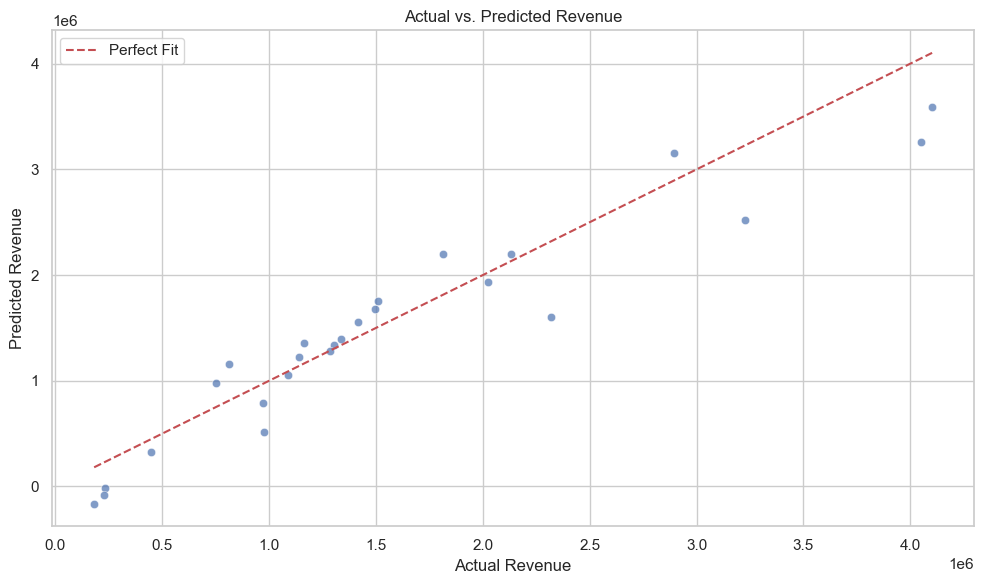

In [82]:
# Plot: Actual vs. Predicted Revenue
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")
plt.title("Actual vs. Predicted Revenue")
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.legend()
plt.tight_layout()
plt.show()

### Learnings

Our baseline model has high accuracy, however it has an overfitting characteristic due to low bias but high variance. There are also many features in this model to take into consideration and we classified them equally. However it is more sensible to spare the baseline macro values from the spend factors and try it out again.

### Baseline Model: Lasso

In [86]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
import numpy as np
import pandas as pd

# ======= Step 1: Create a Copy of the Data to Preserve Original =======
mmm_lasso = mmm_weekly.copy()

# ======= Step 2: Define Factor Groups =======
baseline_factors = ["Promo_Exists", "Consumer_Index", "Inflation_Rate", "Gross_Rating_Point"]

# Spend Factors (Fields with "_Spend")
spend_factors = [col for col in mmm_lasso.columns if "_Spend" in col]

# Ensure Clicks and Views exist before summing them
click_columns = [col for col in mmm_lasso.columns if "_Clicks" in col]
view_columns = [col for col in mmm_lasso.columns if "_Views" in col]

# If Click or View columns exist, create Total_Clicks and Total_Views
if click_columns:
    mmm_lasso["Total_Clicks"] = mmm_lasso[click_columns].sum(axis=1)
else:
    mmm_lasso["Total_Clicks"] = 0  # Avoids KeyError

if view_columns:
    mmm_lasso["Total_Views"] = mmm_lasso[view_columns].sum(axis=1)
else:
    mmm_lasso["Total_Views"] = 0  # Avoids KeyError

# Drop all individual Click & View fields
mmm_lasso.drop(columns=click_columns + view_columns, inplace=True)

# Drop category_ and Sales_Channel_ fields
mmm_lasso.drop(columns=[col for col in mmm_lasso.columns if "category_" in col or "Sales_Channel_" in col], inplace=True)

# Define the final feature sets
extra_features = ["Total_Clicks", "Total_Views"]
predictors = spend_factors + extra_features  # Only include spend and extra features
target = "revenue"

# ======= Step 3: Apply MinMax Scaling to Extra Features =======
scaler = MinMaxScaler()
mmm_lasso[extra_features] = scaler.fit_transform(mmm_lasso[extra_features])

X = mmm_lasso[predictors]
y = mmm_lasso[target]

# ======= Step 4: Train-Test Split =======
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ======= Step 5: Hyperparameter Tuning for Lasso =======
lasso_tuned = Lasso(random_state=42)
param_grid = {"alpha": [0.001, 0.01, 0.1, 1, 10]}  # Tuning range for L1 regularization
grid_search = GridSearchCV(lasso_tuned, param_grid, cv=5, scoring="r2")
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_["alpha"]
print(f"✅ Best Alpha Found: {best_alpha}")

# ======= Step 6: Train Lasso with Optimized Alpha =======
lasso_model = Lasso(alpha=best_alpha, random_state=42)
lasso_model.fit(X_train, y_train)

# Make Predictions
y_pred = lasso_model.predict(X_test)

# Evaluate Model Performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("🔹 Lasso Regression Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")

# ======= Step 7: Display Coefficients for Spend & Extra Features =======
coefficients = pd.DataFrame({
    "Feature": predictors,
    "Coefficient": lasso_model.coef_
}).sort_values(by="Coefficient", ascending=False)

print("\n🔹 Feature Coefficients:")
print(coefficients)

# ======= Step 8: Compute Spend & Extra Features Contribution =======
spend_coefs = dict(zip(spend_factors, lasso_model.coef_[:len(spend_factors)]))
extra_coefs = dict(zip(extra_features, lasso_model.coef_[len(spend_factors):]))

mmm_lasso["spend_contribution"] = mmm_lasso[spend_factors].mul(spend_coefs).sum(axis=1)
mmm_lasso["extra_features_contribution"] = mmm_lasso[extra_features].mul(extra_coefs).sum(axis=1)

# Compute Final Predicted Revenue
mmm_lasso["predicted_revenue_lasso"] = mmm_lasso["spend_contribution"] + mmm_lasso["extra_features_contribution"]

print("\n🔹 Updated DataFrame with Contributions:")
print(mmm_lasso[["Week", "revenue", "spend_contribution", "extra_features_contribution", "predicted_revenue_lasso"]].head())

✅ Best Alpha Found: 0.001
🔹 Lasso Regression Evaluation:
Mean Squared Error (MSE): 89584606532.03
R-squared (R²): 0.92
Root Mean Squared Error (RMSE): 299306.88
Mean Absolute Percentage Error (MAPE): 39.65%

🔹 Feature Coefficients:
                        Feature   Coefficient
16                 Total_Clicks  1.028877e+07
1                 Display_Spend  5.449211e+01
6                   Radio_Spend  5.145808e+01
7                     OOH_Spend  4.372785e+01
10          Video_Spend_Adstock  1.342024e+01
11         Social_Spend_Adstock  9.820312e+00
12  Digital_Audio_Spend_Adstock  4.920267e+00
8          Search_Spend_Adstock  4.251567e+00
13             TV_Spend_Adstock -3.820723e+00
0                  Search_Spend -6.830703e+00
5                      TV_Spend -7.324020e+00
2                   Video_Spend -1.232521e+01
3                  Social_Spend -1.584640e+01
14          Radio_Spend_Adstock -1.689305e+01
4           Digital_Audio_Spend -1.830360e+01
9         Display_Spend_Adstock 

/Users/veyselsonmez/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.049e+12, tolerance: 5.892e+09
  model = cd_fast.enet_coordinate_descent(
/Users/veyselsonmez/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.872e+11, tolerance: 5.583e+09
  model = cd_fast.enet_coordinate_descent(
/Users/veyselsonmez/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

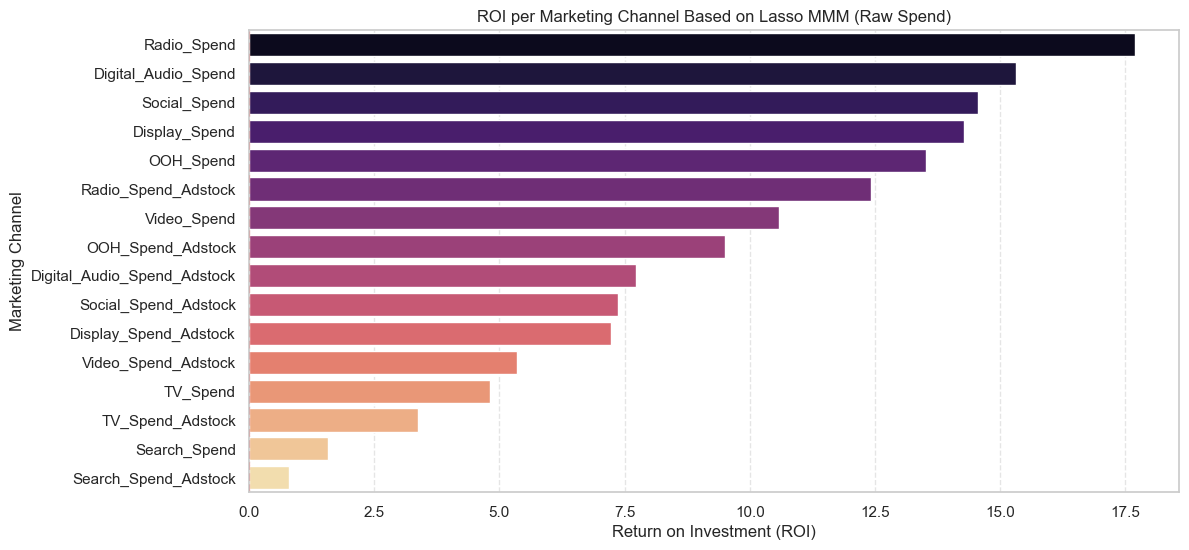

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# ======= Step 1: Calculate ROI per Channel (Using Raw Spend, Not Adstock) =======
roi_per_channel = {}

for channel in raw_spend_factors:  # Use only raw spend variables
    if mmm_lasso[channel].sum() > 0:  # Avoid division by zero
        roi_per_channel[channel] = mmm_lasso["spend_contribution"].sum() / mmm_lasso[channel].sum()

# Convert to DataFrame for visualization
roi_df = pd.DataFrame(list(roi_per_channel.items()), columns=["Channel", "ROI"])
roi_df = roi_df.sort_values(by="ROI", ascending=False)

# ======= Step 2: Plot ROI per Channel =======
plt.figure(figsize=(12, 6))
sns.barplot(x="ROI", y="Channel", data=roi_df, palette="magma")

# Chart Labels & Aesthetics
plt.xlabel("Return on Investment (ROI)")
plt.ylabel("Marketing Channel")
plt.title("ROI per Marketing Channel Based on Lasso MMM (Raw Spend)")
plt.axvline(0, color="red", linestyle="dashed")  # Highlight break-even ROI
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Show Plot
plt.show()

In [93]:
mmm_lasso.columns

Index(['Week', 'Month_Year', 'Promo_Exists', 'Consumer_Index',
       'Inflation_Rate', 'Gross_Rating_Point', 'Month', 'Year', 'Search_Spend',
       'Display_Spend', 'Video_Spend', 'Social_Spend', 'Digital_Audio_Spend',
       'TV_Spend', 'Radio_Spend', 'OOH_Spend', 'revenue', 'salescount',
       'Search_Spend_Adstock', 'Display_Spend_Adstock', 'Video_Spend_Adstock',
       'Social_Spend_Adstock', 'Digital_Audio_Spend_Adstock',
       'TV_Spend_Adstock', 'Radio_Spend_Adstock', 'OOH_Spend_Adstock',
       'predicted_revenue', 'Total_Clicks', 'Total_Views',
       'spend_contribution', 'extra_features_contribution',
       'predicted_revenue_lasso'],
      dtype='object')

### Learnings

Lasso model provided us a strong fit and we realized the importance of merging fields to maximize the fit. Therefore we will drop category values, channel values while aggregating clicks and views to add further media impact.

## XG Boost Based MMM

XGBoost Model Evaluation (Weekly Data):
R-squared (R²): 0.77
Mean Squared Error (MSE): 253573633774.12
Root Mean Squared Error (RMSE): 503560.95
Mean Absolute Percentage Error (MAPE): 44.09%


/var/folders/_1/v_rw1r210972pnhxs2ylkp4h0000gn/T/ipykernel_30483/1001286759.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_importance["Adstock_Pair"] = raw_importance["Feature"].map(spend_mapping)


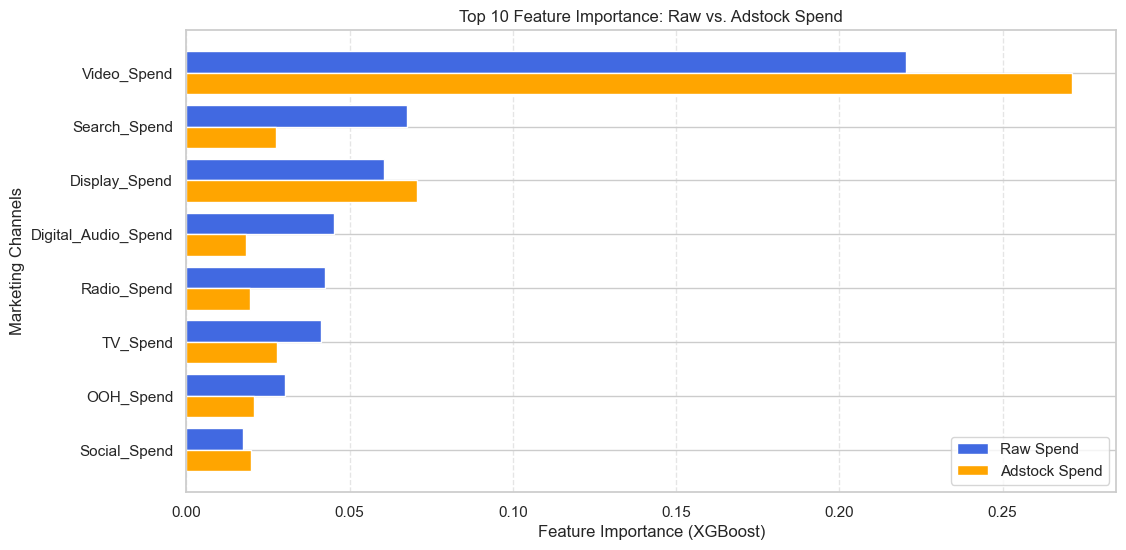

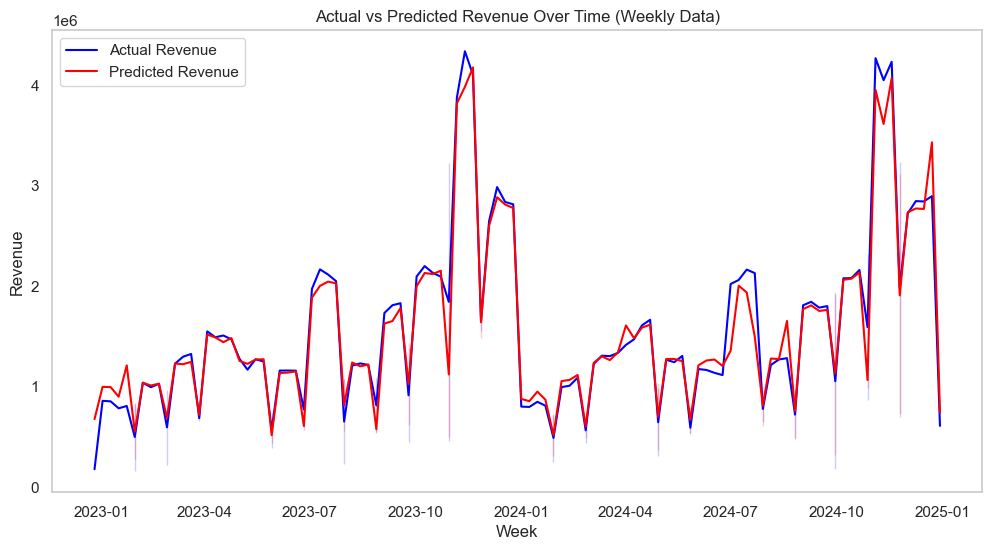

In [95]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# ======= Step 1: Create a Copy of the Data for XGBoost =======
mmm_weekly_xgb = mmm_lasso.copy()

# ======= Step 2: Define Feature Groups =======
raw_spend_factors = [col for col in mmm_weekly_xgb.columns if "_Spend" in col and "_Adstock" not in col]  # Raw Spend
adstock_spend_factors = [col for col in mmm_weekly_xgb.columns if "_Spend_Adstock" in col]  # Adstock Spend

# Ensure they match up
spend_mapping = {raw: adstock for raw in raw_spend_factors for adstock in adstock_spend_factors if raw in adstock}

# Final feature selection (Raw & Adstock Spend)
predictors = raw_spend_factors + adstock_spend_factors
target = "revenue"

# ======= Step 3: Prepare Data for Training =======
X = mmm_weekly_xgb[predictors]
y = mmm_weekly_xgb[target]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ======= Step 4: Initialize and Train XGBoost Model =======
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=10
)

xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# ======= Step 5: Make Predictions =======
y_pred_xgb = xgb_model.predict(X_test)

# ======= Step 6: Evaluate the Model =======
r2_xgb = r2_score(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)

print("XGBoost Model Evaluation (Weekly Data):")
print(f"R-squared (R²): {r2_xgb:.2f}")
print(f"Mean Squared Error (MSE): {mse_xgb:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_xgb:.2%}")

# ======= Step 7: Extract Feature Importance for Raw & Adstock Spend =======
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Separate Raw Spend & Adstock Spend
raw_importance = feature_importance[feature_importance["Feature"].isin(raw_spend_factors)]
adstock_importance = feature_importance[feature_importance["Feature"].isin(adstock_spend_factors)]

# Match Raw Spend & Adstock Spend for sorting
raw_importance["Adstock_Pair"] = raw_importance["Feature"].map(spend_mapping)
merged_importance = raw_importance.merge(adstock_importance, left_on="Adstock_Pair", right_on="Feature", suffixes=("_Raw", "_Adstock"))

# Sort by Raw Spend Impact (Descending)
merged_importance = merged_importance.sort_values(by="Importance_Raw", ascending=False).head(10)

# ======= Step 8: Dual-Color Bar Chart (Raw vs. Adstock Spend Impact) =======
plt.figure(figsize=(12, 6))
bar_width = 0.4  # Width of bars

# Bar positions
raw_positions = np.arange(len(merged_importance))
adstock_positions = raw_positions + bar_width

# Plot bars for Raw Spend
plt.barh(raw_positions, merged_importance["Importance_Raw"], height=bar_width, label="Raw Spend", color="royalblue")

# Plot bars for Adstock Spend
plt.barh(adstock_positions, merged_importance["Importance_Adstock"], height=bar_width, label="Adstock Spend", color="orange")

# Chart Labels
plt.xlabel("Feature Importance (XGBoost)")
plt.ylabel("Marketing Channels")
plt.yticks(raw_positions + bar_width / 2, merged_importance["Feature_Raw"])
plt.title("Top 10 Feature Importance: Raw vs. Adstock Spend")
plt.legend()
plt.gca().invert_yaxis()  # Flip so highest impact is at the top
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Show Plot
plt.show()

# ======= Step 9: Add Predictions to the Weekly DataFrame =======
mmm_weekly_xgb["predicted_revenue_xgb"] = xgb_model.predict(X)

# ======= Step 10: Plot Actual vs Predicted Revenue =======
plt.figure(figsize=(12, 6))
sns.lineplot(x=mmm_weekly_xgb['Week'], y=mmm_weekly_xgb['revenue'], label='Actual Revenue', color='blue')
sns.lineplot(x=mmm_weekly_xgb['Week'], y=mmm_weekly_xgb['predicted_revenue_xgb'], label='Predicted Revenue', color='red')
plt.title('Actual vs Predicted Revenue Over Time (Weekly Data)')
plt.xlabel('Week')
plt.ylabel('Revenue')
plt.legend()
plt.grid()
plt.show()

/var/folders/_1/v_rw1r210972pnhxs2ylkp4h0000gn/T/ipykernel_30483/834129973.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spend_importance["Relative_Impact"] = spend_importance["Importance"] / total_importance  # Normalize to sum 1


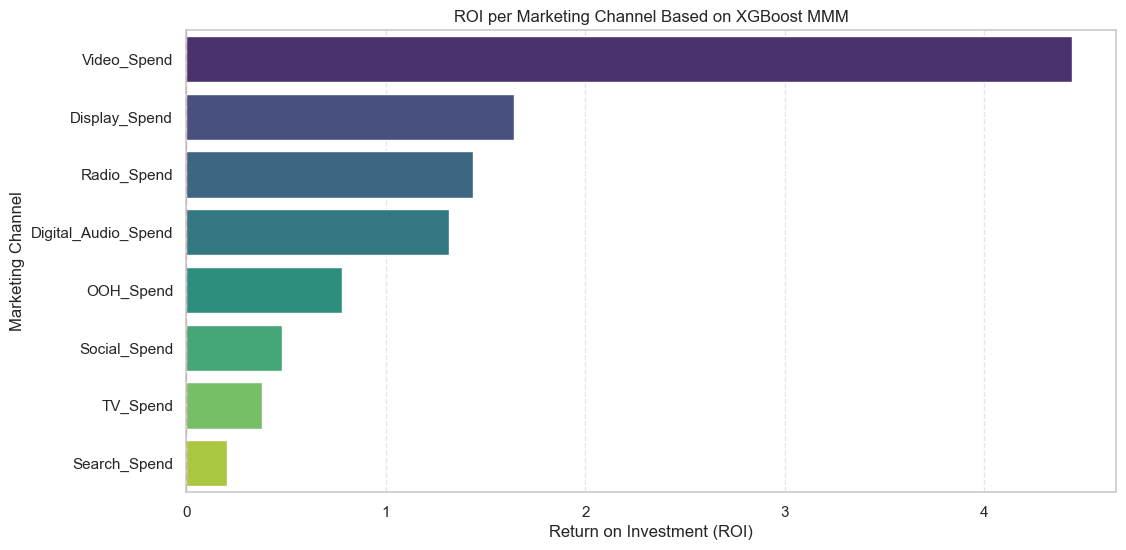

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# ======= Step 1: Extract Feature Importances for Spend Channels =======
feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Importance": xgb_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Filter only spend variables (raw spend only, no Adstock)
spend_importance = feature_importance[feature_importance["Feature"].isin(raw_spend_factors)]

# ======= Step 2: Normalize Feature Importance (Relative to Total Impact) =======
total_importance = spend_importance["Importance"].sum()
spend_importance["Relative_Impact"] = spend_importance["Importance"] / total_importance  # Normalize to sum 1

# ======= Step 3: Compute ROI per Channel =======
roi_per_channel = {}

for channel in raw_spend_factors:
    if mmm_weekly_xgb[channel].sum() > 0:  # Avoid division by zero
        channel_impact = spend_importance[spend_importance["Feature"] == channel]["Relative_Impact"].values[0]
        roi_per_channel[channel] = (channel_impact * mmm_weekly_xgb["spend_contribution"].sum()) / mmm_weekly_xgb[channel].sum()

# Convert to DataFrame for visualization
roi_df = pd.DataFrame(list(roi_per_channel.items()), columns=["Channel", "ROI"])
roi_df = roi_df.sort_values(by="ROI", ascending=False)

# ======= Step 4: Plot ROI per Channel =======
plt.figure(figsize=(12, 6))
sns.barplot(x="ROI", y="Channel", data=roi_df, palette="viridis")

# Chart Labels & Aesthetics
plt.xlabel("Return on Investment (ROI)")
plt.ylabel("Marketing Channel")
plt.title("ROI per Marketing Channel Based on XGBoost MMM")
plt.axvline(0, color="red", linestyle="dashed")  # Highlight break-even ROI
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Show Plot
plt.show()

### Learnings

XG Boost model helped us unlock further insights on how to look into MMM data based on the very exploration of feature importance. R2 is more balanced and realistic here since we reduced the data points particularly.

# Data Tables

In [104]:
# Weekly Data Created Post-EDA
mmm_weekly.head()

# Data for Lasso model
mmm_lasso.head()

# Data for XGB model
mmm_weekly_xgb.head()

,Week,Month_Year,Promo_Exists,Consumer_Index,Inflation_Rate,Gross_Rating_Point,Month,Year,Search_Spend,Display_Spend,...,TV_Spend_Adstock,Radio_Spend_Adstock,OOH_Spend_Adstock,predicted_revenue,Total_Clicks,Total_Views,spend_contribution,extra_features_contribution,predicted_revenue_lasso,predicted_revenue_xgb
0,2022-12-26,2023-01-01,0,110.7,8.7,117.6,1,2023,29977.809599,4207.871135,...,8441.358831,2796.122756,3581.875562,-1.636749e+05,0.000000,0.000000,23521.097447,0.000000e+00,2.352110e+04,6.789102e+05
1,2023-01-02,2023-01-01,0,110.7,8.7,117.6,7,14161,235357.151229,26247.843753,...,51307.797221,17889.698475,26491.139445,9.281854e+05,0.464569,0.533140,21390.478708,1.253758e+06,1.275148e+06,9.998169e+05
2,2023-01-09,2023-01-01,0,110.7,8.7,117.6,7,14161,234186.938263,26545.377010,...,68756.610471,22999.485398,34172.154767,8.771541e+05,0.452675,0.530034,153716.321216,1.151932e+06,1.305649e+06,9.974702e+05
3,2023-01-16,2023-01-01,0,110.7,8.7,117.6,7,14161,236415.991241,25535.800231,...,72191.351037,23632.666305,36960.846071,7.645644e+05,0.431298,0.499337,264814.979649,1.135009e+06,1.399824e+06,9.018654e+05
4,2023-01-23,2023-01-01,0,110.7,8.7,117.6,7,14161,236796.392545,26114.634553,...,71394.920659,24514.634994,36987.176750,1.156196e+06,0.443299,0.510780,443836.388362,1.182808e+06,1.626645e+06,1.213523e+06
